# Clustering 

### KMeans

In [1]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.labels_)
print(kmeans.predict([[0, 0], [12, 3]]))
print(kmeans.cluster_centers_)

[1 1 1 0 0 0]
[1 0]
[[10.  2.]
 [ 1.  2.]]


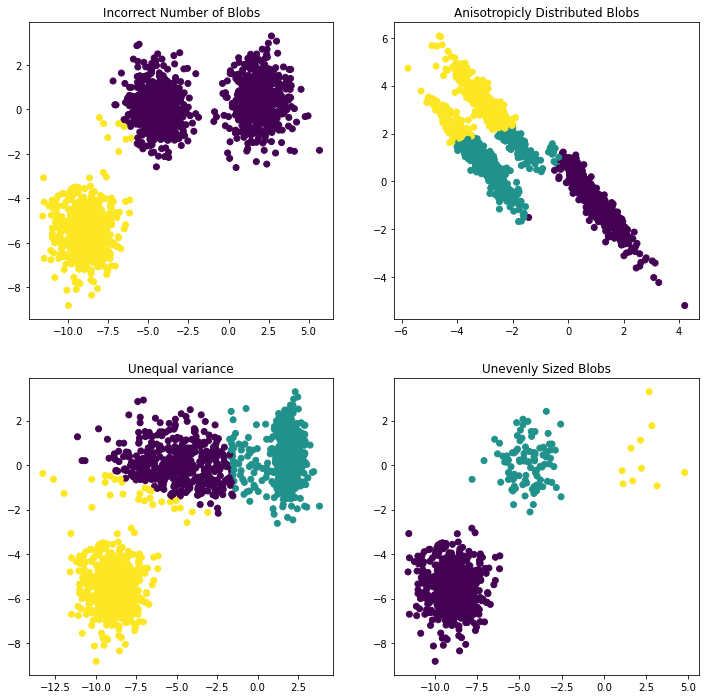

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
plt.figure(figsize=(12, 12))
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state = random_state)
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)
plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

X_varied, y_varied = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)
plt.subplot(223)
plt.scatter(X_varied[:, 0], X[:, 1], c=y_pred)
plt.title("Unequal variance")

X_filtered = np.vstack((X[y==0][:500], X[y==1][:100], X[y==2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)
plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")
plt.show()

Fitting model on a small sub-sample of the data
done in 1.071s.
predicted color indices on the full image (k-means)
done in 0.057s.
Predicting color indices on the full image ( random)
done in 0.748s.


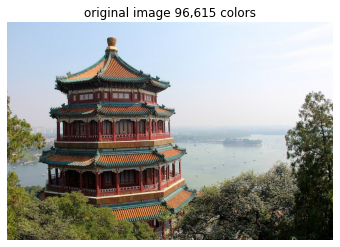

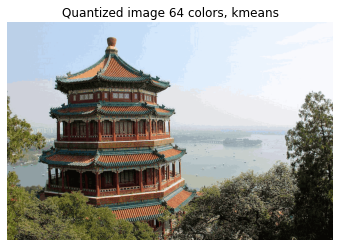

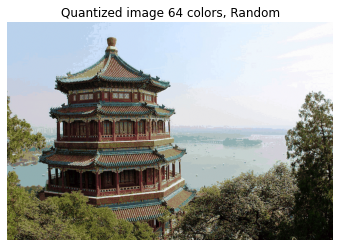

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
n_colors = 64
china = load_sample_image("china.jpg")
china = np.array(china, dtype=np.float64) / 255
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))
print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs."%(time() - t0))

print("predicted color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs."%(time() - t0))

codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image ( random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print("done in %0.3fs."%(time() - t0))

def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('original image 96,615 colors')
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image 64 colors, kmeans')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Quantized image 64 colors, Random')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

In [4]:
import numpy as np
from sklearn.datasets import load_digits
data, labels = load_digits(return_X_y=True)
(n_smaples, n_features), n_digits = data.shape, np.unique(labels).size
print(f"# digits: {n_digits}; #samples: {n_samples}; #features {n_features}")

# digits: 10; #samples: 1500; #features 64


In [5]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
def bench_k_means(kmeans, name, data, labels):
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]
    formatter_result = ("{:9s}\t{:.3f}\t{:.0f}\t{:.3}f\t{:.3}f\t{:.3}f\t{:.3}f\t{:.3}f")
    print(formatter_result.format(*results))

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
Kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name='k-means++', data=data, labels=labels)
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)
pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)
print(82 * '-')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	2.479	33730	0.889f	0.526f	0.661f	0.294f	0.642f
random   	0.153	69952	0.545f	0.616f	0.578f	0.415f	0.574f
PCA-based	0.064	72686	0.636f	0.658f	0.647f	0.521f	0.643f
----------------------------------------------------------------------------------


### MiniBatchKMeans

In [7]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
X = np.array([
    [1, 2], [1, 4], [1, 0], [4, 2], [4, 0], [4, 4], [4, 5], [0, 1], [2, 2], [3, 2], [5, 5], [1, -1]
])
kmeans = MiniBatchKMeans(n_clusters=2, random_state=0, batch_size=6)
kmeans = kmeans.partial_fit(X[0:6, :])
kmeans = kmeans.partial_fit(X[6:12, :])
print(kmeans.cluster_centers_)
print(kmeans.predict([[0, 0], [4, 4]]))
kmeans = MiniBatchKMeans(n_clusters=2, random_state=0, batch_size=6, max_iter=10).fit(X)
print(kmeans.cluster_centers_)
print(kmeans.predict([[0, 0], [4, 4]]))

[[2.  1. ]
 [3.5 4.5]]
[0 1]
[[3.95918367 2.40816327]
 [1.12195122 1.3902439 ]]
[1 0]


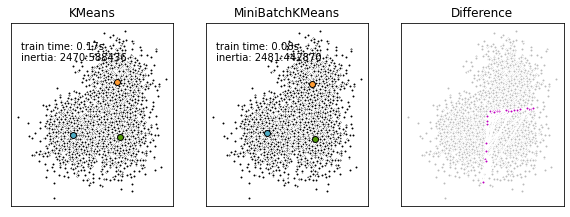

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs
np.random.seed(0)
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size, n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor='k', marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f'%(t_batch, k_means.inertia_))

ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor='k', marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f'%(t_mini_batch, mbk.inertia_))

different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)
for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels==k))
    
identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w', markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w', markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())
plt.show()

### Afinity Propagation

In [12]:
from sklearn.cluster import AffinityPropagation
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0], [1, 4], [4, 4], [4, 0]])
clustering = AffinityPropagation(random_state=5).fit(X)
print(clustering.labels_)
print(clustering.predict([[0, 0], [4, 4]]))
print(clustering.cluster_centers_)

[0 0 1 0 2 1]
[1 2]
[[1 4]
 [1 0]
 [4 4]]


In [15]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5, random_state=0)

af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d'%n_clusters_)
print("Homogeneity: %0.3f"%metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f"%metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f"%metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"%metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"%metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" %metrics.silhouette_score(X, labels, metric='sqeuclidean'))

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


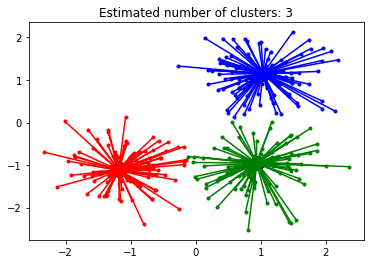

In [16]:
import matplotlib.pyplot as plt
from itertools import cycle
plt.close('all')
plt.figure(1)
plt.clf()
colors = cycle('bgrcmykbgrcmykbrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
plt.title('Estimated number of clusters: %d'%n_clusters_)
plt.show()

Automatically created module for IPython interactive environment


Fetching quote history for 'AAPL'
Fetching quote history for 'AIG'
Fetching quote history for 'AMZN'
Fetching quote history for 'AXP'
Fetching quote history for 'BA'
Fetching quote history for 'BAC'
Fetching quote history for 'CAJ'
Fetching quote history for 'CAT'
Fetching quote history for 'CL'
Fetching quote history for 'CMCSA'
Fetching quote history for 'COP'
Fetching quote history for 'CSCO'
Fetching quote history for 'CVC'
Fetching quote history for 'CVS'
Fetching quote history for 'CVX'
Fetching quote history for 'DD'
Fetching quote history for 'DELL'
Fetching quote history for 'F'
Fetching quote history for 'GD'
Fetching quote history for 'GE'
Fetching quote history for 'GS'
Fetching quote history for 'GSK'
Fetching quote history for 'HD'
Fetching quote history for 'HMC'
Fetching quote history for 'HPQ'
Fetching quote history for 'IBM'
Fetching quote history for 'JPM'
Fetching quote history for 'K'
Fetching quote history for 'KMB'
Fetching quote history for 'KO'
Fetching quote h

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Comcast, Cablevision, Time Warner
Cluster 3: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 4: Cisco, Dell, HP, IBM, Microsoft, SAP, Texas Instruments
Cluster 5: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 6: AIG, American express, Bank of America, Caterpillar, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, Marriott, 3M, Ryder, Wells Fargo, Wal-Mart
Cluster 7: McDonald's
Cluster 8: GlaxoSmithKline, Novartis, Pfizer, Sanofi-Aventis, Unilever
Cluster 9: Kellogg, Coca Cola, Pepsi
Cluster 10: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 11: Canon, Honda, Navistar, Sony, Toyota, Xerox


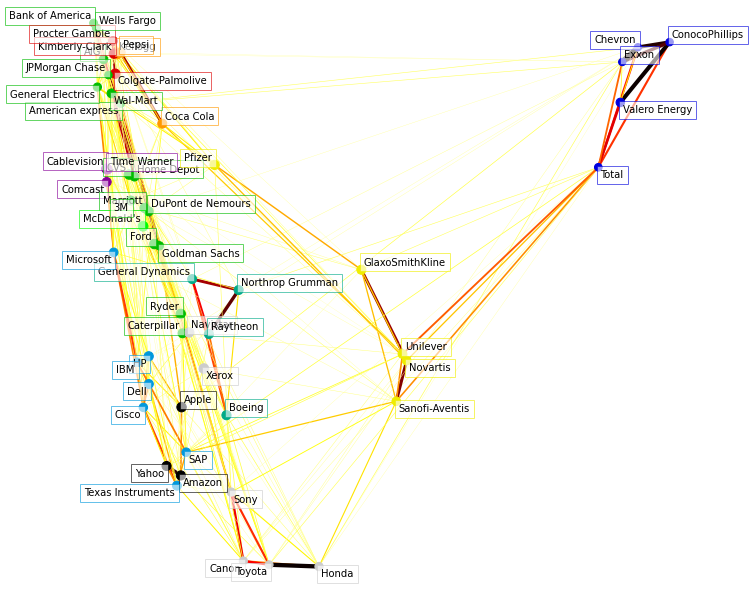

In [17]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas as pd

from sklearn import cluster, covariance, manifold

print(__doc__)


# #############################################################################
# Retrieve the data from Internet

# The data is from 2003 - 2008. This is reasonably calm: (not too long ago so
# that we get high-tech firms, and before the 2008 crash). This kind of
# historical data can be obtained for from APIs like the quandl.com and
# alphavantage.co ones.

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}


symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    print('Fetching quote history for %r' % symbol, file=sys.stderr)
    url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/'
           'master/financial-data/{}.csv')
    quotes.append(pd.read_csv(url.format(symbol)))

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_,
                                         random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

### MeanShift

In [2]:
from sklearn.cluster import MeanShift
import numpy as np
X = np.array([[1, 1], [2, 1], [1, 0], [4, 7], [3, 5], [3, 6]])
clustering = MeanShift(bandwidth=2).fit(X)
print(clustering.labels_)
print(clustering.predict([[0, 0], [5, 5]]))
clustering

[1 1 1 0 0 0]
[1 0]


MeanShift(bandwidth=2)

number of estimated clusters: 3


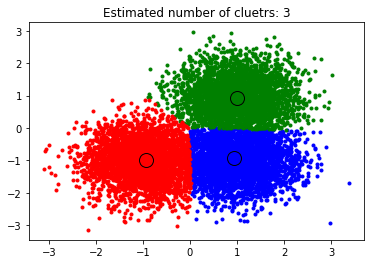

In [6]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters: %d"%n_clusters_)
import matplotlib.pyplot as plt
from itertools import cycle
plt.figure(1)
plt.clf()
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_member = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_member, 0], X[my_member, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
plt.title('Estimated number of cluetrs: %d'%n_clusters_)
plt.show()

### Spectral Clustering

In [7]:
from sklearn.cluster import SpectralClustering
import numpy as np
X = np.array([[1, 1], [2, 1], [1, 0], [4, 7], [3, 5], [3, 6]])
clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X)
print(clustering.labels_)
print(clustering)

[1 1 1 0 0 0]
SpectralClustering(assign_labels='discretize', n_clusters=2, random_state=0)


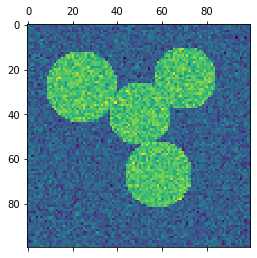

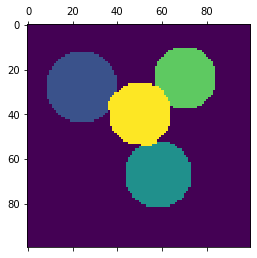

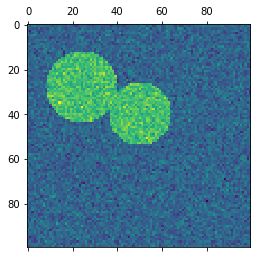

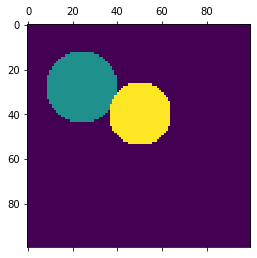

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
l = 100
x, y = np.indices((l, l))
center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)
radius1, radius2, radius3, radius4 = 16, 14, 15, 14
circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

img = circle1 + circle2 + circle3 + circle4
mask = img.astype(bool)
img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)
graph = image.img_to_graph(img, mask=mask)

graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = np.full(mask.shape, -1)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)
graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters = 2, eigen_solver = 'arpack')
label_im = np.full(mask.shape, -1)
label_im[mask] = labels
plt.matshow(img)
plt.matshow(label_im)
plt.show()

### AgglomerativeClustering

In [21]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
print(clustering)
print(clustering.labels_)

AgglomerativeClustering()
[1 1 1 0 0 0]


Done
ward :	2850.59s
average :	2861.32s
complete :	2872.09s
single :	2881.20s


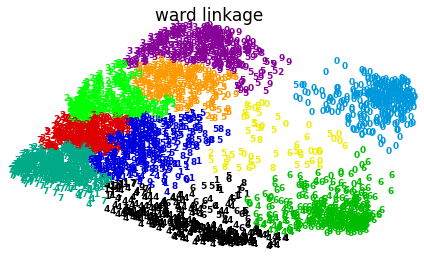

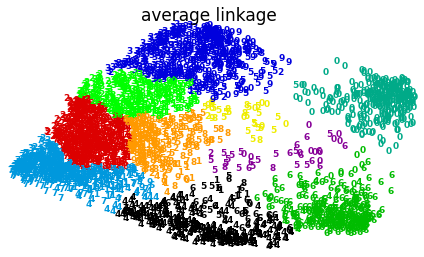

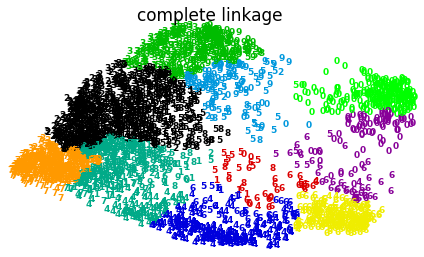

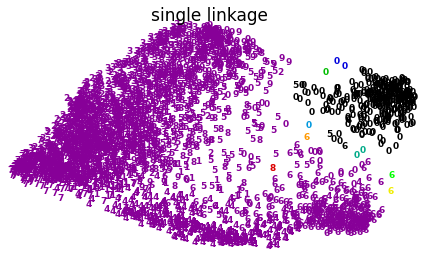

In [22]:
from time import time
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn import manifold, datasets
X, y = datasets.load_digits(return_X_y=True)
n_samples, n_features = X.shape
np.random.seed(0)
def nudge_images(X, y):
    shift = lambda x: ndimage.shift(x.reshape((8, 8)), .3 * np.random.normal(size=2), mode='constant').ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y

X, y = nudge_images(X, y)

def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]), color=plt.cm.nipy_spectral(labels[i] / 10),
                 fontdict={'weight':'bold', 'size':9})
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done")
    
from sklearn.cluster import AgglomerativeClustering
for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage = linkage, n_clusters = 10)
    to = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs"%(linkage, time() - t0))
    plot_clustering(X_red, clustering.labels_, "%s linkage"%linkage)
plt.show()

In [1]:
import time as time
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage.data import coins
from skimage.transform import rescale
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils.fixes import parse_version

computer structured hierarchical clustering...
Elapsed time:  0.5674567222595215
Number of pixels:  4697
Number of clusters:  27


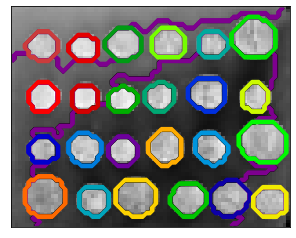

In [4]:
if parse_version(skimage.__version__) >= parse_version('0.14'):
    rescale_params = {'anti_aliasing': False, 'multichannel':False}
else:
    rescale_params = {}

orig_coins = coins()
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", **rescale_params)
X = np.reshape(rescaled_coins, (-1, 1))
connectivity = grid_to_graph(*rescaled_coins.shape)

print("computer structured hierarchical clustering...")
st = time.time()
n_clusters = 27
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label==l, colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

In [5]:
skimage.__version__

'0.18.3'

Compute unstructured hierarchical clustering...
Elapsed time: 0.127819s
Number of points: 1500
Compute structured hierarchical clustering...
Elapsed time: 0.062479s
Number of points: 1500


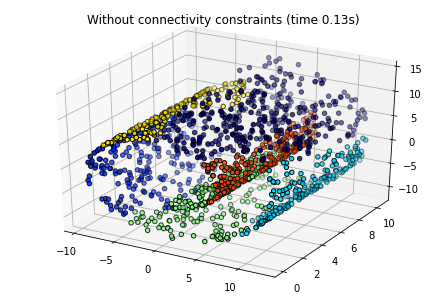

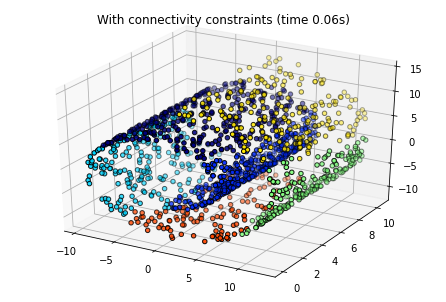

In [12]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll

n_smaples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_smaples, noise=noise)
X[:, 1] *= .5

print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %fs"%elapsed_time)
print("Number of points: %i"%label.size)

fig = plt.figure()
ax = p3.Axes3D(fig)
for l in np.unique(label):
    ax.scatter(X[label==l, 0], X[label == l, 1], X[label == l, 2], color=plt.cm.jet(float(l) / np.max(label + 1)),
             s = 20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)'%elapsed_time)

from sklearn.neighbors import kneighbors_graph
connectivity =  kneighbors_graph(X, n_neighbors=10, include_self=False)

print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %2fs"%elapsed_time)
print("Number of points: %i" %label.size)

fig = plt.figure()
ax = p3.Axes3D(fig)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label==l, 2], color=plt.cm.jet(float(l) / np.max(label + 1)), 
              s=20, edgecolor='k')
plt.title("With connectivity constraints (time %.2fs)"%elapsed_time)
plt.show()

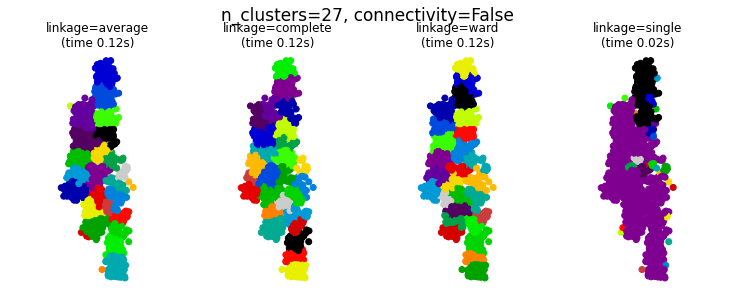

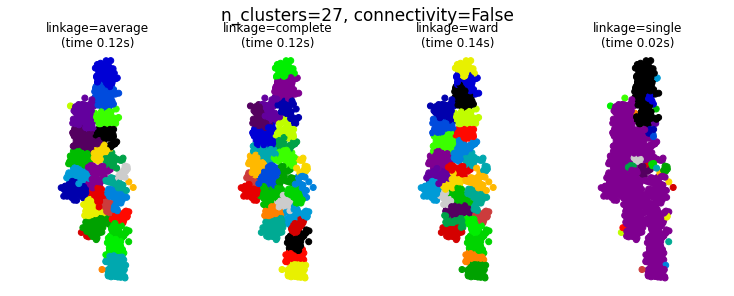

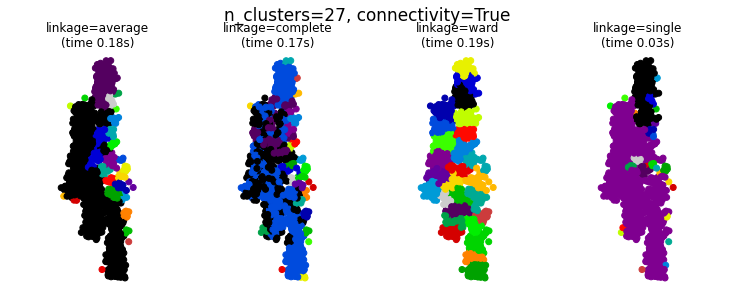

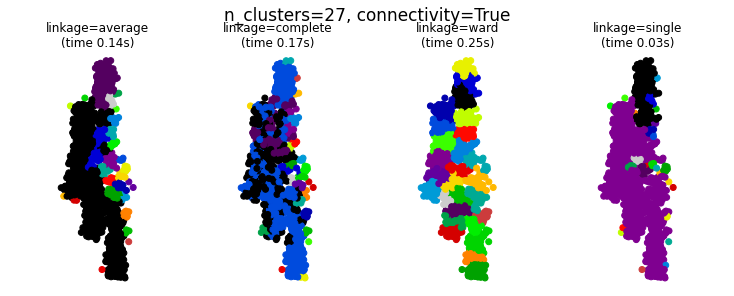

In [19]:
import time 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_smaples))
x = t * np.cos(1)
y = t * np.sin(t)

X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

knn_graph = kneighbors_graph(X, 30, include_self = False)

for connectivity in (None, knn_graph):
    for n_cluster in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(("average", "complete", "ward", "single")):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(linkage = linkage, connectivity=connectivity, n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s\n(time %.2fs)'%(linkage, elapsed_time), fontdict = dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')
            plt.subplots_adjust(bottom=0, top=.83, wspace=0, left=0, right=1)
            plt.suptitle('n_clusters=%i, connectivity=%r'%(n_clusters, connectivity is not None), size=17)
plt.show()

### DBSCAN

In [21]:
from sklearn.cluster import DBSCAN
import numpy as np
X = np.array([[1, 2], [2, 2], [2, 3], [8, 7], [8, 8], [25, 80]])
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
print(clustering.labels_)
print(clustering)

[ 0  0  0  1  1 -1]
DBSCAN(eps=3, min_samples=2)


Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


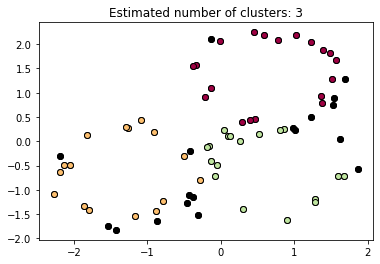

In [25]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std = 0.4, random_state=0)
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps = 0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d"%n_clusters_)
print("Estimated number of noise points: %d"%n_noise_)
print("Homogeneity: %0.3f"%metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f"%metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f"%metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"%metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"%metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" %metrics.silhouette_score(X, labels))

import matplotlib.pyplot as plt
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
plt.title("Estimated number of clusters: %d"%n_clusters_)
plt.show()

### OPTICS

In [2]:
from sklearn.cluster import OPTICS
import numpy as np
X = np.array([[1, 2], [2, 5], [3, 6], [8, 7], [8, 8], [7, 3]])
clustering = OPTICS(min_samples=2).fit(X)
clustering.labels_

array([0, 0, 0, 1, 1, 1])

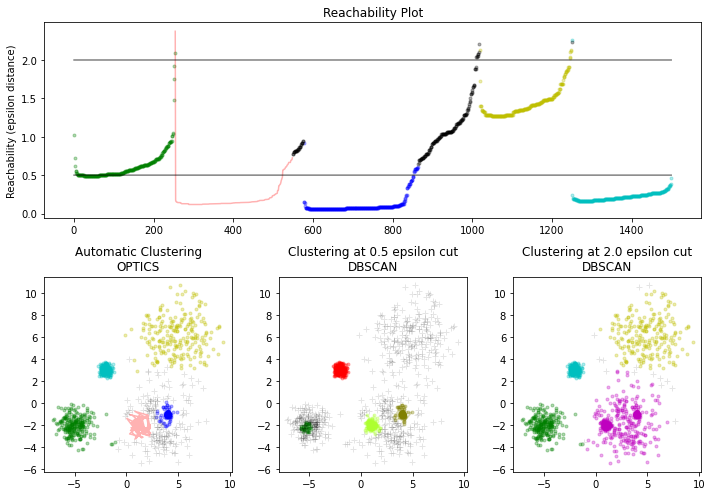

In [12]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
n_points_per_cluster = 250
C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))
clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)
clust.fit(X)
labels_050 = cluster_optics_dbscan(reachability=clust.reachability_, core_distances=clust.core_distances_,
                                   ordering = clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_, core_distances=clust.core_distances_,
                                   ordering = clust.ordering_, eps=2)
space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

colors = ['g.', 'r', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

colors = ['g.', 'r', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

colors = ['g.', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')
plt.tight_layout()
plt.show()

In [16]:
clust.ordering_

array([  0,   3,   6, ..., 908, 873, 866])

### Birch

In [17]:
from sklearn.cluster import Birch
X = [[0, 1], [0.3, 1], [-0.3, 1], [0, -1], [0.3, -1], [-0.3, -1]]
brc = Birch(n_clusters = None)
brc.fit(X)
brc.predict(X)

array([0, 0, 0, 1, 1, 1])

In [18]:
brc.labels_

array([0, 0, 0, 1, 1, 1])

BIRCH without gobal clustering as the final steptook 9.11 seconds
n_clusters: 158
BIRCH with global clustering as the final steptook 9.08 seconds
n_clusters: 100
Time taken to run MiniBatchKMeans 8.77 seconds


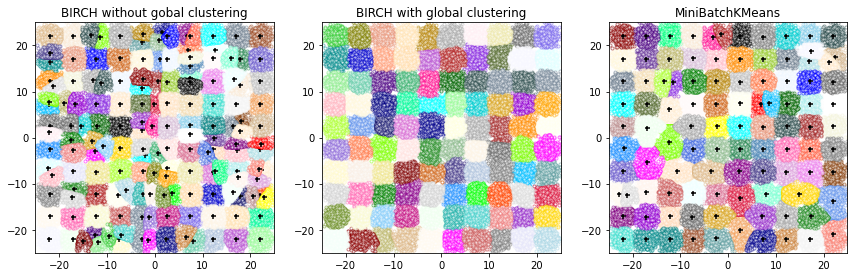

In [27]:
from itertools import cycle
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets import make_blobs

xx = np.linspace(-22, 22, 10)
yy = np.linspace(-22, 22, 10)
xx, yy = np.meshgrid(xx, yy)
n_centers = np.hstack((np.ravel(xx)[:, np.newaxis], np.ravel(yy)[:, np.newaxis]))
X, y = make_blobs(n_samples=100000, centers=n_centers, random_state=0)
colors_ = cycle(colors.cnames.keys())
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

birch_models = [Birch(threshold=1.7, n_clusters=None), Birch(threshold=1.7, n_clusters=100)]
final_step = ['without gobal clustering', 'with global clustering']

for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_model.fit(X)
    time_ = time() - t
    print("BIRCH %s as the final steptook %0.2f seconds"%(info, (time() - t)))
    
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters: %d"%n_clusters)
    
    ax = fig.add_subplot(1, 3, ind + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.scatter(X[mask, 0], X[mask, 1], c='w', edgecolor = col, marker='.', alpha=0.5)
        if birch_model.n_clusters is None:
            ax.scatter(this_centroid[0], this_centroid[1], marker='+', c='k', s=25)
    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title("BIRCH %s"%info)

mbk = MiniBatchKMeans(init='k-means++', n_clusters=100, batch_size=100, n_init = 10, max_no_improvement=10, verbose=0, 
                     random_state=0)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds"%t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)
for this_centroid, k, col in zip(mbk.cluster_centers_, range(n_clusters), colors_):
    mask = mbk.labels_ == k
    ax.scatter(X[mask, 0], X[mask, 1], marker='.', c='w', edgecolor=col, alpha=0.5)
    ax.scatter(this_centroid[0], this_centroid[1], marker='+', c='k', s=25)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_title("MiniBatchKMeans")
ax.set_autoscaley_on(False)
plt.show()

In [28]:
colors_

# Clustering performance evaluation

### Rand Index

In [2]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
metrics.adjusted_rand_score(labels_true, labels_pred)

0.24242424242424246

In [3]:
labels_pred = [1, 1, 0, 0, 3, 3]
metrics.adjusted_rand_score(labels_true, labels_pred)

0.24242424242424246

In [4]:
labels_pred = labels_true[:]
metrics.adjusted_rand_score(labels_true, labels_pred)

1.0

In [5]:
labels_true = [0, 0, 0, 0, 0, 0, 1, 1]
labels_pred = [0, 1, 2, 3, 4, 5, 5, 6]
metrics.adjusted_rand_score(labels_true, labels_pred)

-0.07207207207207207

### Mutual Information based

In [6]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
metrics.adjusted_mutual_info_score(labels_true, labels_pred)

0.29879245817089006

In [7]:
labels_pred = [1, 1, 0, 0, 3, 3]
metrics.adjusted_mutual_info_score(labels_true, labels_pred)

0.29879245817089006

In [8]:
labels_pred = labels_true[:]
metrics.adjusted_mutual_info_score(labels_true, labels_pred)

1.0

In [9]:
metrics.normalized_mutual_info_score(labels_true, labels_pred)

1.0

In [10]:
labels_true = [0, 1, 2, 0, 3, 4, 5, 1]
labels_pred = [1, 1, 0, 0, 2, 2, 2, 2]
metrics.adjusted_mutual_info_score(labels_true, labels_pred)

-0.16666666666666655

Computed adjusted_rand_score for 10 values of n_clusters and n_samples=100
done in 0.042s
Computed v_measure_score for 10 values of n_clusters and n_samples=100
done in 0.031s
Computed ami_score for 10 values of n_clusters and n_samples=100
done in 0.371s
Computed mutual_info_score for 10 values of n_clusters and n_samples=100
done in 0.047s
Computing adjusted_rand_score for 10 values of n_cluesters and n_samples=1000
done in 0.031s
Computing v_measure_score for 10 values of n_cluesters and n_samples=1000
done in 0.031s
Computing ami_score for 10 values of n_cluesters and n_samples=1000
done in 0.154s
Computing mutual_info_score for 10 values of n_cluesters and n_samples=1000
done in 0.054s


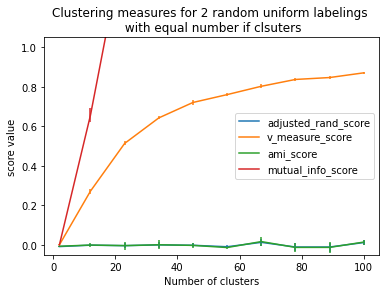

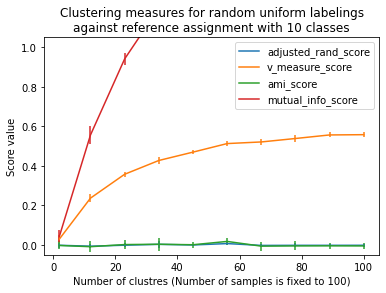

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics

def uniform_labelings_scores(score_func, n_smaples, n_clusters_range, fixed_n_classes=None, n_runs=5, seed=42):
    random_labels = np.random.RandomState(seed).randint
    scores = np.zeros((len(n_clusters_range), n_runs))
    if fixed_n_classes is not None:
        labels_a = random_labels(low=0, high=fixed_n_classes, size=n_samples)
        
    for i, k in enumerate(n_clusters_range):
        for j in range(n_runs):
            if fixed_n_classes is None:
                labels_a = random_labels(low=0, high=k, size=n_smaples)
            labels_b = random_labels(low=0, high=k, size=n_smaples)
            scores[i, j] = score_func(labels_a, labels_b)
    return scores

def ami_score(U, V):
    return metrics.adjusted_mutual_info_score(U, V)

score_funcs = [
    metrics.adjusted_rand_score,
    metrics.v_measure_score,
    ami_score,
    metrics.mutual_info_score,
]

n_samples = 100
n_clusters_range = np.linspace(2, n_samples, 10).astype(int)

plt.figure(1)

plots = []
names = []
for score_func in score_funcs:
    print("Computed %s for %d values of n_clusters and n_samples=%d"%(score_func.__name__, len(n_clusters_range),
                                                                      n_samples))
    t0 =time()
    scores = uniform_labelings_scores(score_func, n_samples, n_clusters_range)
    print("done in %0.3fs"%(time() - t0))
    plots.append(plt.errorbar(n_clusters_range, np.median(scores, axis=1), scores.std(axis=1))[0])
    names.append(score_func.__name__)

plt.title("Clustering measures for 2 random uniform labelings \n with equal number if clsuters")
plt.xlabel("Number of clusters")
plt.ylabel('score value')
plt.legend(plots, names)
plt.ylim(bottom=-0.05, top=1.05)

n_smaples = 1000
n_clusters_range = np.linspace(2, 100, 10).astype(int)
n_classes = 10

plt.figure(2)

plots = []
names = []
for score_func in score_funcs:
    print("Computing %s for %d values of n_cluesters and n_samples=%d"%(score_func.__name__, len(n_clusters_range),
                                                                        n_smaples))
    t0 = time()
    scores = uniform_labelings_scores(score_func, n_samples, n_clusters_range, fixed_n_classes = n_classes)
    print("done in %0.3fs"%(time() - t0))
    plots.append(plt.errorbar(n_clusters_range, scores.mean(axis=1), scores.std(axis=1))[0])
    names.append(score_func.__name__)
plt.title("Clustering measures for random uniform labelings\nagainst reference assignment with %d classes" %n_classes)
plt.xlabel('Number of clustres (Number of samples is fixed to %d)'%n_samples)
plt.ylabel("Score value")
plt.ylim(bottom=-0.05, top=1.05)
plt.legend(plots, names)
plt.show()

### Homogeneity, completeness and V-measure

In [26]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))

0.6666666666666669
0.420619835714305


In [28]:
metrics.v_measure_score(labels_true, labels_pred)

0.5158037429793889

In [29]:
metrics.v_measure_score(labels_true, labels_pred, beta=1.8)

0.48447946234141737

In [30]:
metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)


(0.6666666666666669, 0.420619835714305, 0.5158037429793889)

In [31]:
labels_pred = [0, 0, 0, 1, 2, 2]
metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)

(1.0, 0.6853314789615865, 0.8132898335036762)

###  Fowlkes-Mallows score

In [33]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
metrics.fowlkes_mallows_score(labels_true, labels_pred)

0.4714045207910317

In [35]:
labels_pred = [1, 1, 0, 0, 3, 3]
metrics.fowlkes_mallows_score(labels_true, labels_pred)

0.4714045207910317

In [36]:
labels_pred = labels_true[:]
metrics.fowlkes_mallows_score(labels_true, labels_pred)

1.0

In [37]:
labels_true = [0, 1, 2, 0, 3, 4, 5, 1]
labels_pred = [1, 1, 0, 0, 2, 2, 2, 2]
metrics.fowlkes_mallows_score(labels_true, labels_pred)

0.0

### Silhouette Coefficient

In [40]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
X, y = datasets.load_iris(return_X_y=True)
import numpy as np
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.5528190123564094

### Calinski-Harabasz Index

In [2]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
X, y = datasets.load_iris(return_X_y=True)
import numpy as np
from sklearn.cluster import KMeans
kmeans_models = KMeans(n_clusters=3, random_state=1).fit(X)
labels = kmeans_models.labels_
metrics.calinski_harabasz_score(X, labels)

561.62775662962

### Davies-Bouldin Index

In [4]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
kmeans = KMeans(n_clusters=3, random_state=1).fit(X)
labels = kmeans.labels_
davies_bouldin_score(X, labels)

0.6619715465007497

### Contingency Matrix

In [5]:
from sklearn.metrics.cluster import contingency_matrix
x = ["a", "a", "a", "b", "b", "b"]
y = [0, 0, 1, 1, 2, 2]
contingency_matrix(x, y)

array([[2, 1, 0],
       [0, 1, 2]])

# Decomposing signals in components (matrix factorization problems)

## Principal component analysis (PCA)

In [9]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.99244289 0.00755711]
[6.30061232 0.54980396]


In [10]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.99244289 0.00755711]
[6.30061232 0.54980396]


In [11]:
pca = PCA(n_components=1, svd_solver='arpack')
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.99244289]
[6.30061232]


expained variance ratio (first two components): [0.92461872 0.05306648]


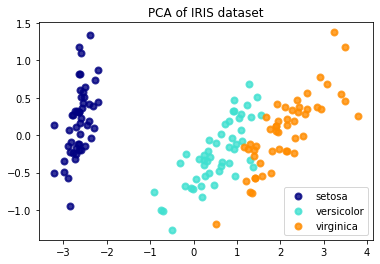

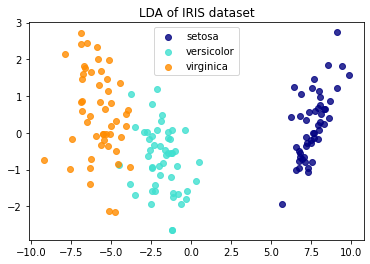

In [12]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)
print('expained variance ratio (first two components): %s'%str(pca.explained_variance_ratio_))
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y==i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y== i, 1], alpha=.8, color=color, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')
plt.show()

best n_components by PCA CV = 10
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 10
best n_components by PCA CV = 45
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 49


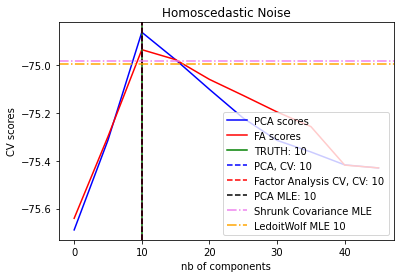

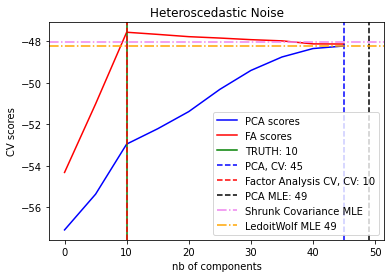

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
n_samples, n_features, rank = 1000, 50, 10
sigma = 1
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

X_homo = X + sigma * rng.randn(n_samples, n_features)

sigmas = sigma * rng.rand(n_features)
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

n_components = np.arange(0, n_features, 5)

def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()
    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))
    return pca_scores, fa_scores

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage':shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))

def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

for X, title in [(X_homo, 'Homoscedastic Noise'),
                (X_hetero, 'Heteroscedastic Noise')]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]
    
    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_
    print("best n_components by PCA CV = %d"%n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" %n_components_fa)
    print("best n_components by PCA MLE = %d"%n_components_pca_mle)
    
    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label = 'PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d'%rank, linestyle='-')
    plt.axvline(n_components_pca, color='b', label='PCA, CV: %d'%n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r', label='Factor Analysis CV, CV: %d'%n_components_fa, linestyle='--')
    plt.axvline(n_components_pca_mle, color='k', label='PCA MLE: %d'%n_components_pca_mle, linestyle='--')
    plt.axhline(shrunk_cov_score(X), color='violet', label='Shrunk Covariance MLE', linestyle="-.")
    plt.axhline(lw_score(X), color='orange', label='LedoitWolf MLE %d'%n_components_pca_mle, linestyle="-.")
    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)
plt.show()

### Incremental PCA

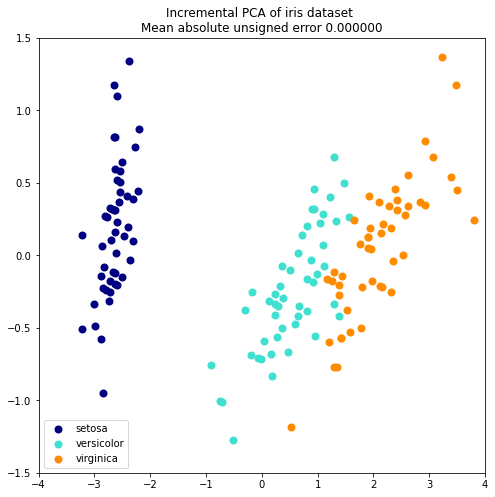

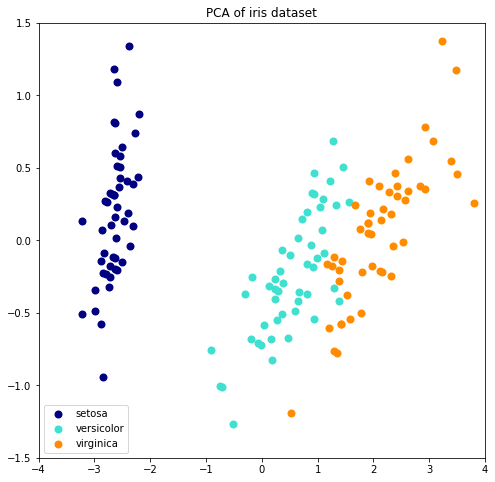

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
iris = load_iris()
X = iris.data
y = iris.target
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=10)
X_ipca = ipca.fit_transform(X)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

colors = ['navy', 'turquoise', 'darkorange']
for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1], color=color, lw=2, label=target_name)
    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_pca)).mean()
        plt.title(title + " of iris dataset \nMean absolute unsigned error %.6f"%err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])
plt.show()

In [14]:
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people

Total datasets size:
n_samples: 904
n_features: 1850
n_classes: 4
Extracting the top 150 eigenface from 678 faces
done in 0.676s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.033s
Fitting the classifier to the training set
done in 34.543s
Best estimator found by grid seach:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting people's names on the test set
done in 0.048135s
                   precision    recall  f1-score   support

  Donald Rumsfeld       0.73      0.84      0.78        32
    George W Bush       0.89      0.90      0.90       129
Gerhard Schroeder       0.82      0.62      0.71        29
       Tony Blair       0.78      0.81      0.79        36

         accuracy                           0.84       226
        macro avg       0.81      0.79      0.79       226
     weighted avg       0.84      0.84      0.84       226

[[ 27   4   0   1]
 [  7 116   2   4]
 [  2   6  18   3]
 [  1   4   2  29]]


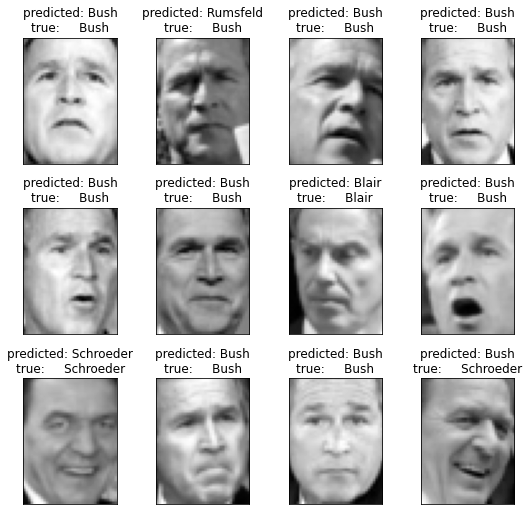

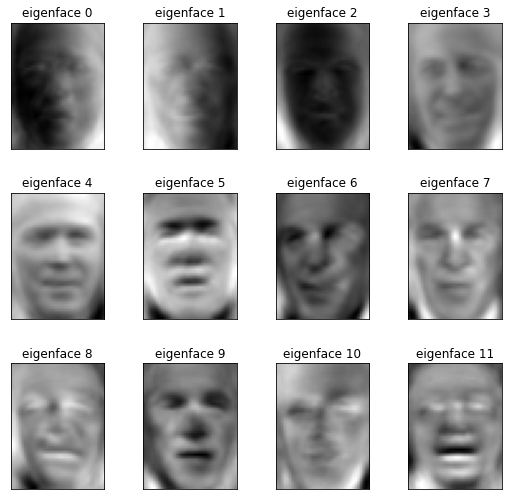

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total datasets size:")
print("n_samples: %d"%n_samples)
print("n_features: %d"%n_features)
print("n_classes: %d"%n_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
n_components = 150
print("Extracting the top %d eigenface from %d faces"%(n_components, X_train.shape[0]))
to = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs"%(time() - to))
eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs"%(time() - t0))

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs"%(time() - t0))
print("Best estimator found by grid seach:")
print(clf.best_estimator_)

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %03fs"%(time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

def plot_galary(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_galary(X_test, prediction_titles, h, w)
eigenface_titles = ["eigenface %d"%i for i in range(eigenfaces.shape[0])]
plot_galary(eigenfaces, eigenface_titles, h, w)
plt.show()

### Kernel PCA

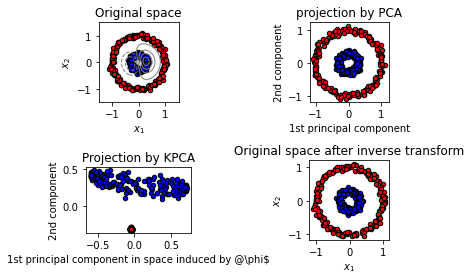

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)
kpca = KernelPCA(kernel='rbf', fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)
pca = PCA()
X_pca = pca.fit_transform(X)
plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1
plt.scatter(X[reds, 0], X[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue", s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("projection by PCA")

plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by @\phi$")
plt.ylabel("2nd component")
plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(X_back[reds, 0], X_back[reds, 1], c="red", s= 20, edgecolor='k')
plt.scatter(X_back[blues, 0], X_back[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
plt.show()

In [19]:
from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA
X, _ = load_digits(return_X_y = True)
transformer = KernelPCA(n_components=7, kernel="linear")
X_transformed = transformer.fit_transform(X)
X_transformed.shape

(1797, 7)

### SparsePCA

In [23]:
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA
X, _ = make_friedman1(n_samples=200, n_features=30, random_state=0)
transformer = SparsePCA(n_components=5, random_state=0)
transformer.fit(X)
X_transformed = transformer.transform(X)
print(X_transformed.shape)
np.mean(transformer.components_==0)

(200, 5)


0.9666666666666667

## Truncated singular value decomposition and latent semantic analysis

In [1]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
X = sparse_random(100, 100, density = 0.01, format='csr', random_state=42)
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[0.0646051  0.06339479 0.06394407 0.05352903 0.04062679]
0.2860997781448579
[1.55360944 1.5121377  1.51052009 1.37056529 1.19917045]


## Dictionary Learning 

### Saprse coding with a precomputed dictionary

In [7]:
import numpy as np
from sklearn.decomposition import SparseCoder
X = np.array([[-1, -1, -1], [0, 0, 3]])
dictionary = np.array([
    [0, 1, 0],
    [-1, -1, 2],
    [1, 1, 1],
    [0, 1, 1],
    [0, 2, 1],
], dtype=np.float64)
coder = SparseCoder(dictionary=dictionary, transform_algorithm='lasso_lars', transform_alpha=1e-10)
coder.transform(X)

array([[ 0.,  0., -1.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.]])

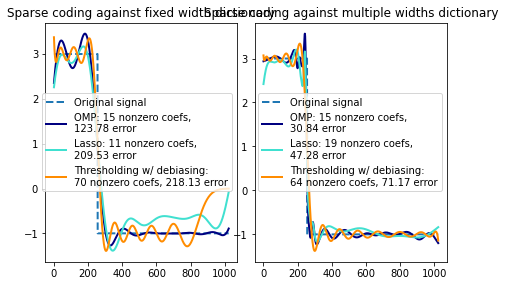

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import SparseCoder
from sklearn.utils.fixes import np_version, parse_version

def ricker_function(resolution, center, width):
    x = np.linspace(0, resolution - 1, resolution)
    x = ((2 / (np.sqrt(3 * width) * np.pi ** .25)) * (1 -(x - center) ** 2 / width ** 2) * 
         np.exp(-(x-center) ** 2 / (  2 * width ** 2)))
    return x

def ricker_matrix(width, resolution, n_components):
    centers = np.linspace(0, resolution - 1, n_components)
    D = np.empty((n_components, resolution))
    for i, center in enumerate(centers):
        D[i] = ricker_function(resolution, center, width)
    D /= np.sqrt(np.sum(D ** 2, axis=1))[:, np.newaxis]
    return D

resolution = 1024
subsampling = 3
width = 100
n_components = resolution // subsampling
D_fixed = ricker_matrix(width=width, resolution=resolution, n_components=n_components)
D_multi = np.r_[tuple(ricker_matrix(width=w, resolution=resolution, n_components=n_components // 5)
                      for w in (10, 50, 100, 500, 1000))]
y = np.linspace(0, resolution - 1, resolution)
first_quarter = y < resolution / 4
y[first_quarter] = 3
y[np.logical_not(first_quarter)] = -1
estimators = [('OMP', 'omp', None, 15, 'navy'), ('Lasso', 'lasso_lars', 2, None, 'turquoise')]
lw = 2
lstsq_rcond = None if np_version > parse_version('1.14') else -1
for subplot, (D, title) in enumerate(zip((D_fixed, D_multi), ('fixed width', 'multiple widths'))):
    plt.subplot(1, 2, subplot + 1)
    plt.title('Sparse coding against %s dictionary' %title)
    plt.plot(y, lw=lw, linestyle="--", label="Original signal")
    for title, algo, alpha, n_nonzero, color in estimators:
        coder = SparseCoder(dictionary=D, transform_n_nonzero_coefs = n_nonzero,
                            transform_algorithm=algo)
        x = coder.transform(y.reshape(1, -1))
        density = len(np.flatnonzero(x))
        x = np.ravel(np.dot(x, D))
        squared_error = np.sum((y - x) ** 2)
        plt.plot(x, color=color, lw=lw, label='%s: %s nonzero coefs, \n%.2f error'%(title, density, squared_error))
    coder = SparseCoder(dictionary = D, transform_algorithm='threshold', transform_alpha=20)
    x = coder.transform(y.reshape(1, -1))
    _, idx = np.where(x != 0)
    x[0, idx], _, _, _ = np.linalg.lstsq(D[idx, :].T, y, rcond=lstsq_rcond) 
    x = np.ravel(np.dot(x, D))
    squared_error = np.sum((y - x) ** 2)
    plt.plot(x, color='darkorange', lw=lw, label='Thresholding w/ debiasing: \n%d nonzero coefs, %.2f error'
             %(len(idx), squared_error))
    plt.axis('tight')
    plt.legend(shadow=False, loc="best")
plt.subplots_adjust(.04, .07, .97, .90, .09, .2)
plt.show()

### Dictionary Learning

In [19]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning
X, dictionary, code = make_sparse_coded_signal(n_samples=100, n_components=15, n_features=20, n_nonzero_coefs=10,
                                               random_state=42)
dict_learner = DictionaryLearning(n_components=15, transform_algorithm='lasso_lars', random_state=42)
X_transformed = dict_learner.fit_transform(X)

Automatically created module for IPython interactive environment
Distorting image...
Extracting reference patches...
done in 0.05s.
Learning the dictionary...
done in 10.36s.
Extracting noisy patches... 
done in 0.02s.
Orthogonal Matching Pursuit
1 atom...
done in 2.62s.
Orthogonal Matching Pursuit
2 atoms...
done in 5.09s.
Least-angle regression
5 atoms...
done in 55.39s.
Thresholding
 alpha=0.1...
done in 0.57s.


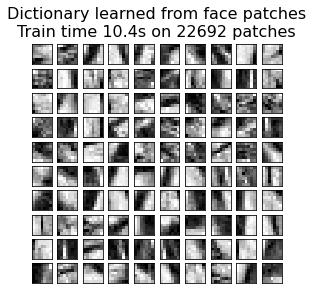

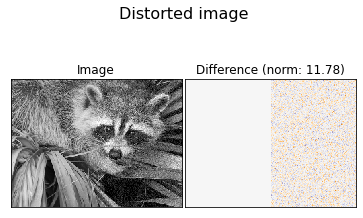

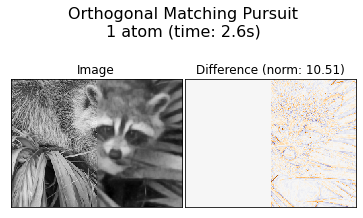

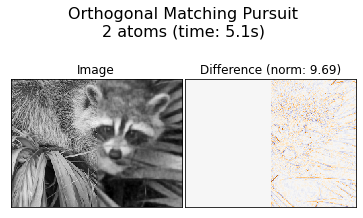

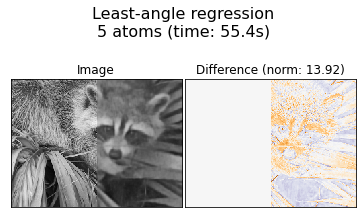

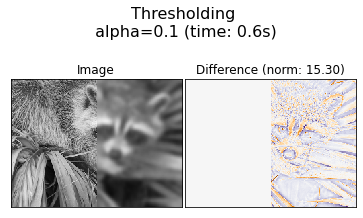

In [21]:
print(__doc__)

from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d


try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

# downsample for higher speed
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
height, width = face.shape

# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

# #############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


# #############################################################################
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

show_with_diff(distorted, face, 'Distorted image')

# #############################################################################
# Extract noisy patches and reconstruct them using the dictionary

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}),
    ('Least-angle regression\n5 atoms', 'lars',
     {'transform_n_nonzero_coefs': 5}),
    ('Thresholding\n alpha=0.1', 'threshold', {'transform_alpha': .1})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()

### Mini Batch Dictionary Learning

In [22]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import MiniBatchDictionaryLearning
X, dictionary, code = make_sparse_coded_signal(n_samples=100, n_components=15, n_features=20, n_nonzero_coefs=10, 
                                              random_state=42)
dict_learner = MiniBatchDictionaryLearning(n_components=15, transform_algorithm="lasso_lars", random_state=42)
X_transformed = dict_learner.fit_transform(X)

Automatically created module for IPython interactive environment
Learning the dictionary... 
Partial fit of  100 out of 2400
Partial fit of  200 out of 2400
[MiniBatchKMeans] Reassigning 16 cluster centers.
Partial fit of  300 out of 2400
Partial fit of  400 out of 2400
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Partial fit of 2200 out of 2400
Partial fit of 2300 out of 2400
Partial fit of 2400 out of 2400
done in 6.31s.


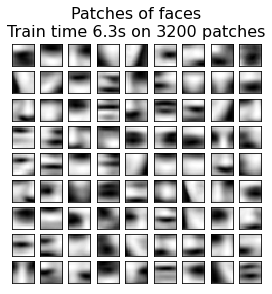

In [23]:
print(__doc__)

import time

import matplotlib.pyplot as plt
import numpy as np


from sklearn import datasets
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

faces = datasets.fetch_olivetti_faces()

# #############################################################################
# Learn the dictionary of images

print('Learning the dictionary... ')
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True)
patch_size = (20, 20)

buffer = []
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50,
                                  random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print('Partial fit of %4i out of %i'
                  % (index, 6 * len(faces.images)))

dt = time.time() - t0
print('done in %.2fs.' % dt)

# #############################################################################
# Plot the results
plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())


plt.suptitle('Patches of faces\nTrain time %.1fs on %d patches' %
             (dt, 8 * len(faces.images)), fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

### Factor Analysis

In [1]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FactorAnalysis
X, _ = load_digits(return_X_y=True)
transformer = FactorAnalysis(n_components=7, random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

(1797, 7)

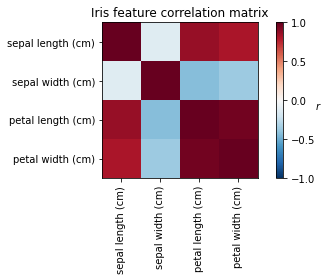

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
data = load_iris()
X = StandardScaler().fit_transform(data["data"])
feature_names = data["feature_names"]
ax = plt.axes()
im = ax.imshow(np.corrcoef(X.T), cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(list(feature_names), rotation=90)
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(list(feature_names))
plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Iris feature correlation matrix")
plt.tight_layout()



PCA:

[[ 0.52106591  0.37741762]
 [-0.26934744  0.92329566]
 [ 0.5804131   0.02449161]
 [ 0.56485654  0.06694199]]


Unrotated FA:

[[ 0.88096009 -0.4472869 ]
 [-0.41691605 -0.55390036]
 [ 0.99918858  0.01915283]
 [ 0.96228895  0.05840206]]


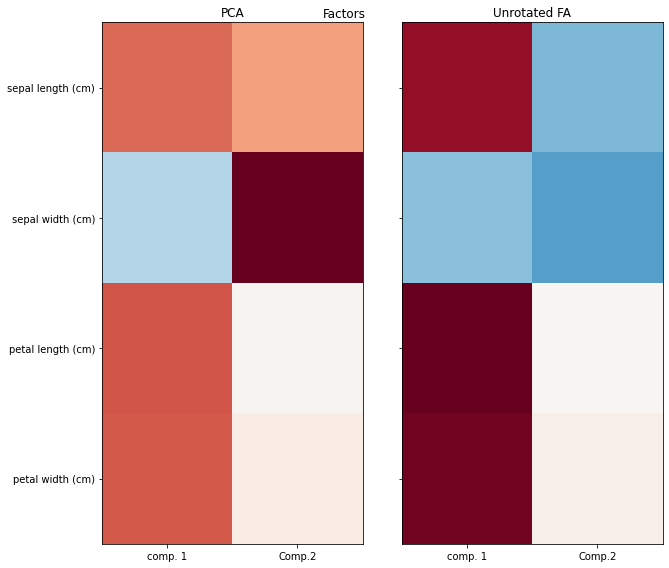

In [6]:
n_comps = 2
methods = [('PCA', PCA()), ('Unrotated FA', FactorAnalysis())]
fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 8))
for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components = n_comps)
    fa.fit(X)
    components = fa.components_.T
    print("\n\n%s:\n"%method)
    print(components)
    vmax = np.abs(components).max()
    ax.imshow(components, cmap='RdBu_r', vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['comp. 1', 'Comp.2'])
fig.suptitle("Factors")
plt.tight_layout()
plt.show()

### FastICA (Fast Independent Component Analysis

In [7]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
X, _ = load_digits(return_X_y = True)
transformer = FastICA(n_components=7, random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(1797, 7)

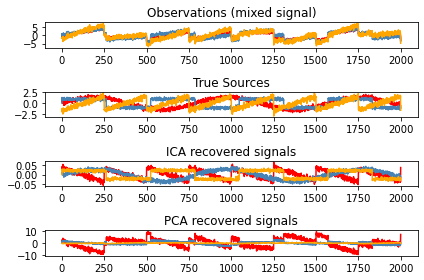

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA, PCA
np.random.seed(0)
n_samples=2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time))
s3 = signal.sawtooth(2 * np.pi * time)
S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)
S /= S.std(axis=0)
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])
X = np.dot(S, A.T)
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)
A_ = ica.mixing_
pca = PCA(n_components = 3)
H = pca.fit_transform(X)
plt.figure()
models = [X, S, S_, H]
names = ["Observations (mixed signal)", "True Sources", 'ICA recovered signals', 'PCA recovered signals']
colors = ["red", "steelblue", 'orange']
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.tight_layout()
plt.show()

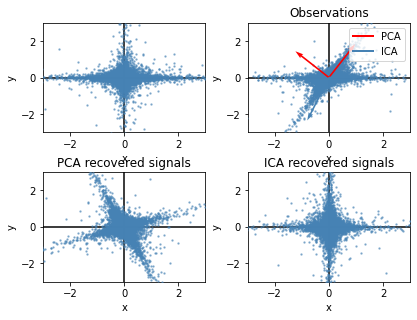

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
rng = np.random.RandomState(42)
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.
A = np.array([[1, 1], [0, 2]])
X = np.dot(S, A.T)
pca=PCA()
S_pca_= pca.fit(X).transform(X)
ica = FastICA(random_state=rng)
S_ica_ = ica.fit(X).transform(X)
S_ica_ /= S_ica_.std(axis=0)

def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10, color='steelblue', alpha=0.5)
    if axis_list is not None:
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver((0, 0), (0, 0), x_axis, y_axis, zorder=11, width=0.01, scale=6, color=color)
    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure()
plt.subplot(2, 2, 1)
plot_samples(S / S.std())
axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title("Observations")
plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title("PCA recovered signals")

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()

### Non-negative matrix factorization (NMF or NNMF)

In [20]:
import numpy as np
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_
H

array([[2.09783018, 0.30560234],
       [2.13443044, 2.13171694]])

Loading dataset...
done in 3.999s.
Extracting tf-idf features for NMF...
done in 1.295s.
Extracting tf features for LDA...
done in 1.254s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.585s.
[[0.00823964 0.06919427 0.15426254 ... 0.27827566 0.1528297  0.05816641]
 [0.01772593 0.         0.01036082 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.03358272 0.        ]
 ...
 [0.         0.01034455 0.04690092 ... 0.03247968 0.         0.        ]
 [0.17826006 0.         0.03819383 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.06743348 0.        ]]


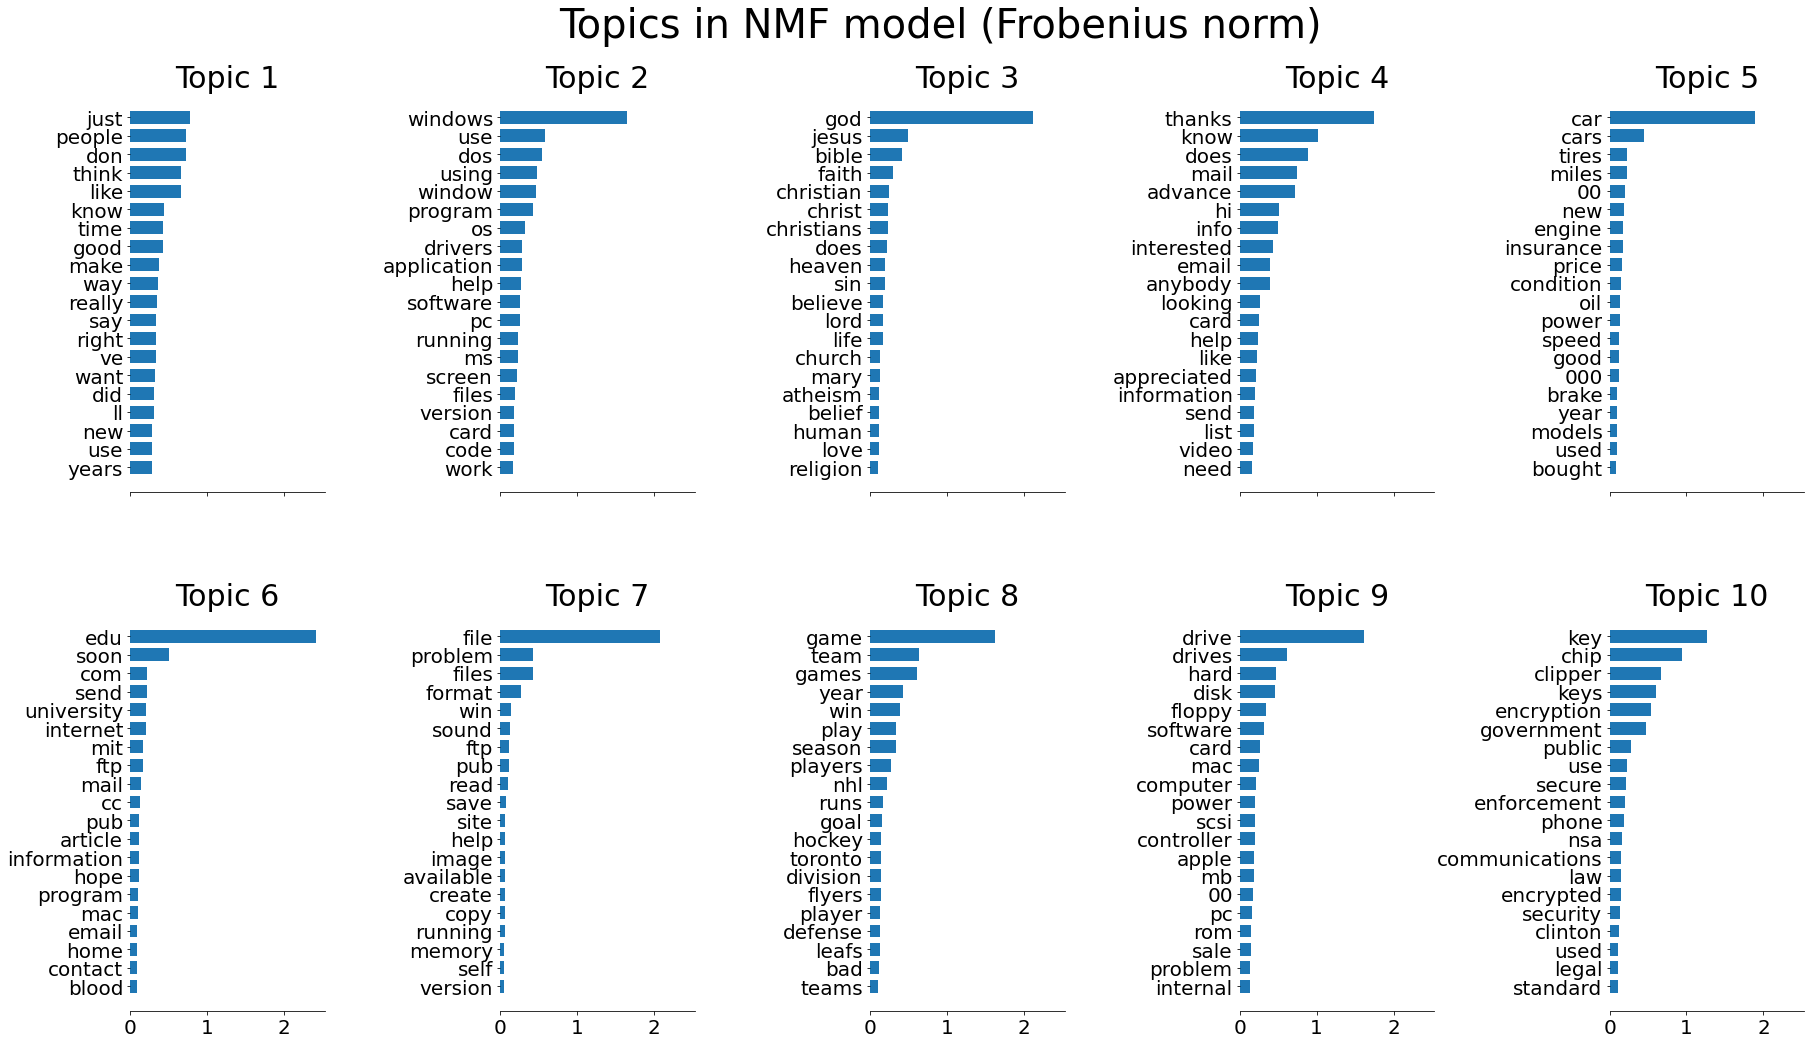



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 2.174s.
[[0.00000000e+00 2.82862017e-02 1.75342287e-02 ... 1.91329434e-01
  1.05408411e-01 7.79844560e-02]
 [8.14580389e-03 0.00000000e+00 7.06586737e-16 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.12352261e-01 0.00000000e+00]
 ...
 [0.00000000e+00 4.09624085e-02 2.30913533e-02 ... 1.40013785e-01
  4.57593957e-02 9.42823603e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  4.81660842e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.74844575e-01 0.00000000e+00]]


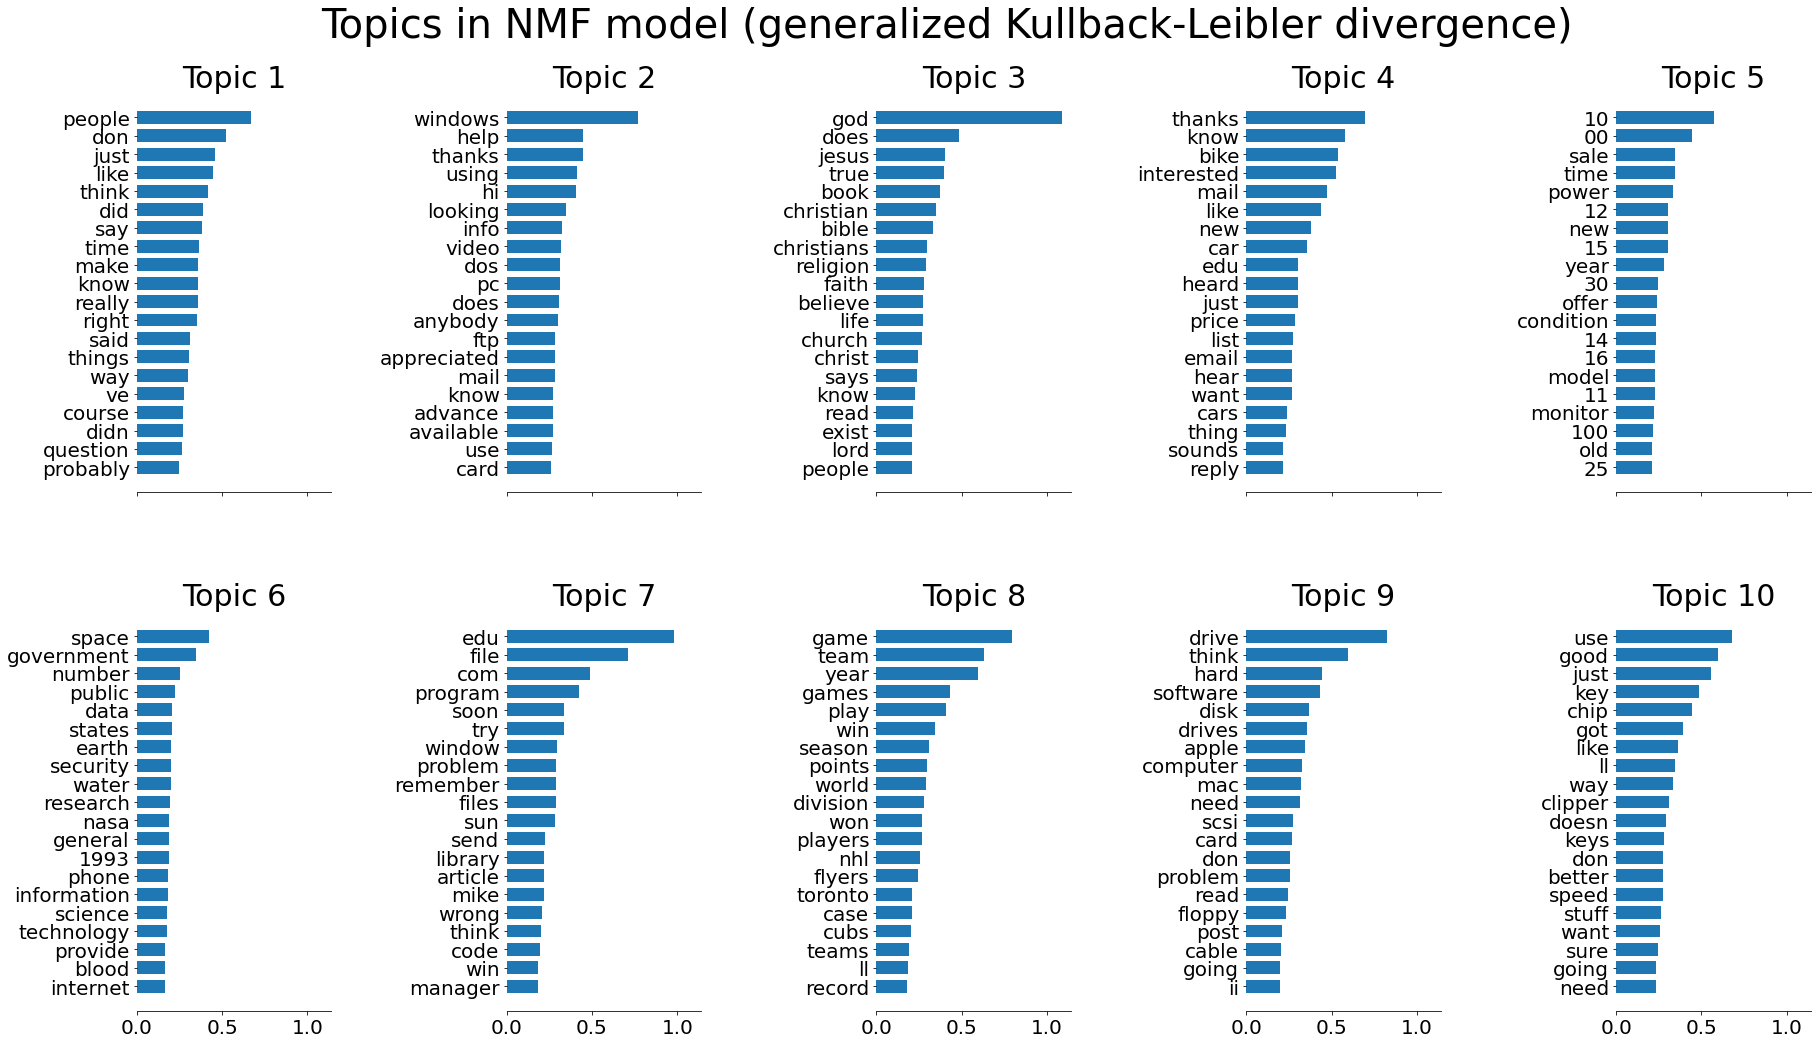



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 9.040s.
[[ 4.96604155  4.3537397  21.42539886 ...  1.57926488  1.33933502
   1.20988436]
 [ 0.48391034  1.85845783 14.04720958 ... 74.59501615 59.36116266
   0.27698642]
 [ 0.18708486  0.13728929  0.31409364 ...  1.02679042  2.56259123
   0.13662652]
 ...
 [ 3.22343848 39.1368944  11.24910558 ... 23.37779481  3.06315114
   0.15230766]
 [ 1.41871388 47.53082031 16.14390001 ... 82.46751192 16.51319941
  28.11660323]
 [ 4.02759659  1.24781464 13.26101699 ... 29.0225105   0.24834416
   0.13033208]]


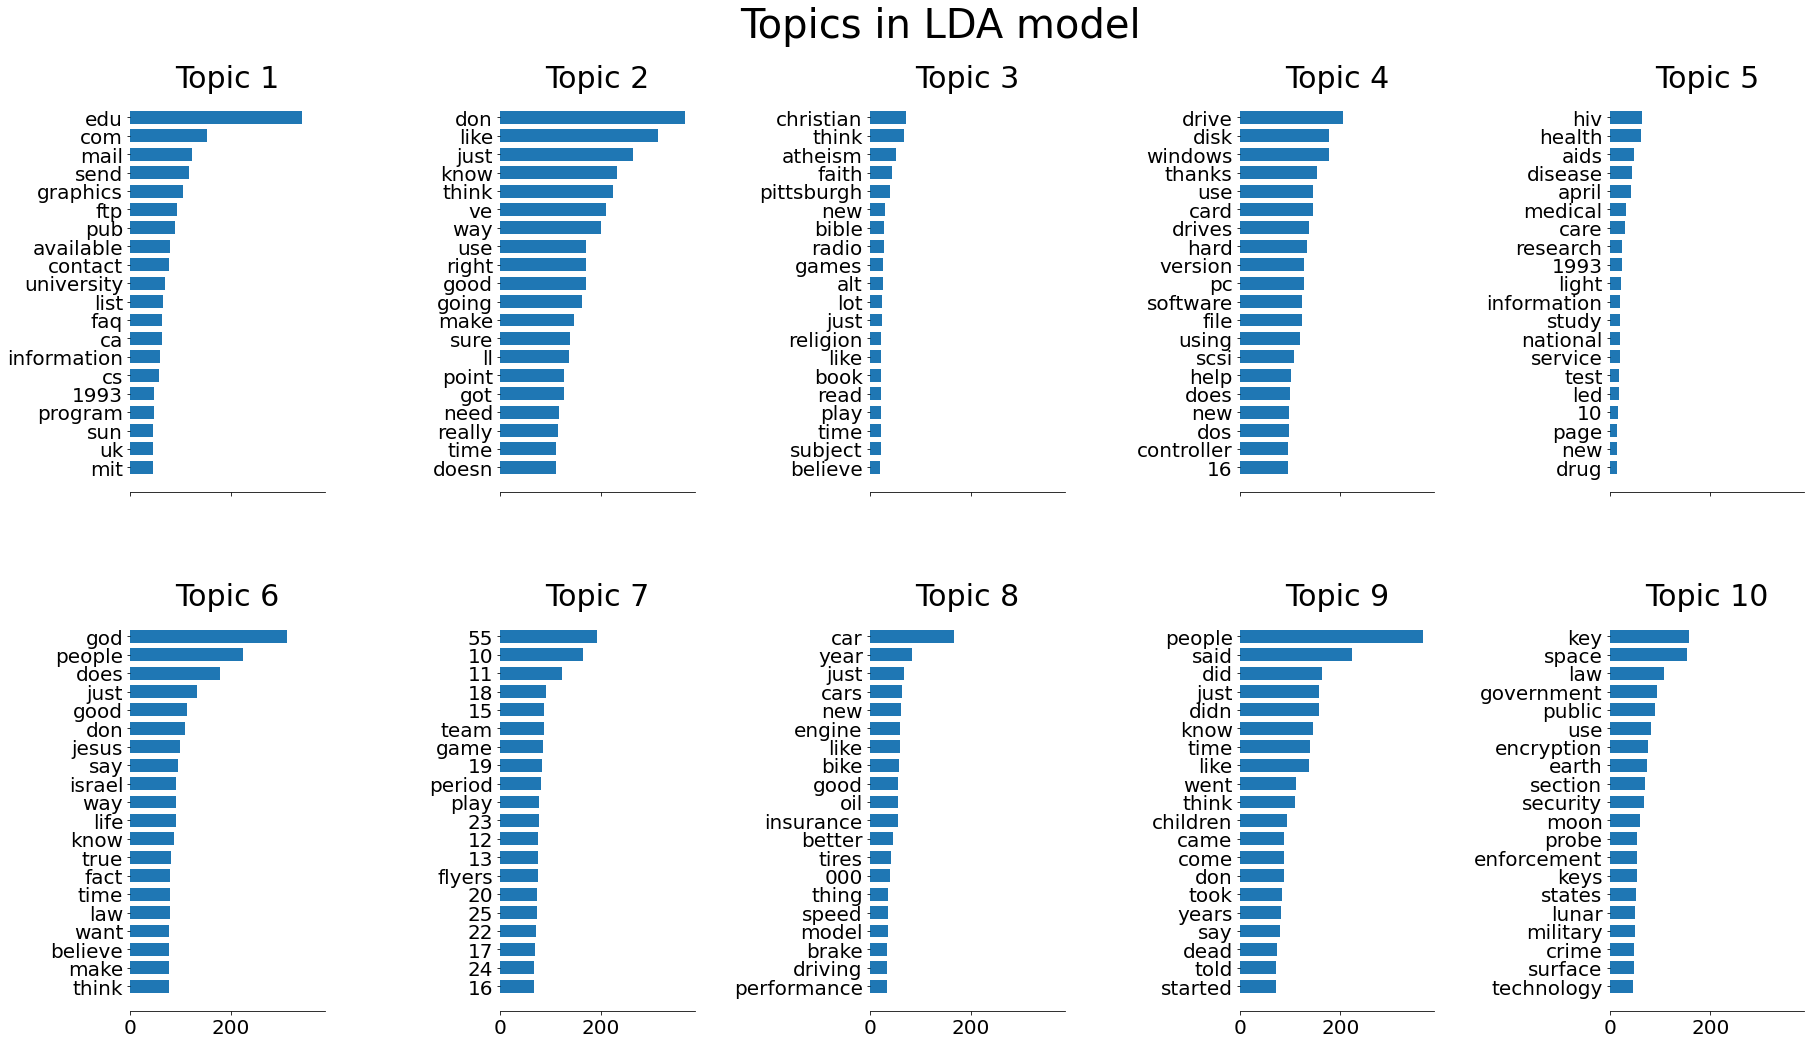

In [22]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    print(model.components_)
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

### LatentDirichletAllocation

In [31]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
X, _ = make_multilabel_classification(random_state=0)
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)
lda.transform(X[-2:])

array([[0.00360392, 0.25499205, 0.0036211 , 0.64236448, 0.09541846],
       [0.15297572, 0.00362644, 0.44412786, 0.39568399, 0.003586  ]])